<a href="https://colab.research.google.com/github/rahiakela/practical-machine-learning-with-tensorflow/blob/week-7/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting

This tutorial is an introduction to time series forecasting using Recurrent Neural Networks (RNNs). This is covered in two parts: first, you will forecast a univariate time series, then you will forecast a multivariate time series.

## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset

This tutorial uses a [weather time series dataset](https://www.bgc-jena.mpg.de/wetter/) recorded by the [Max-Planck-Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/index.php/Main/HomePage).

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [0]:
zip_path = tf.keras.utils.get_file(origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
                                   fname='jena_climate_2009_2016.csv.zip', extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [30]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


As you can see above, an observation is recorded every 10 mintues. This means that, for a single hour, you will have 6 observations. Similarly, a single day will contain 144 (6x24) observations. 

Given a specific time, let's say you want to predict the temperature 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 720(5x144) observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict. The `target_size` is the label that needs to be predicted.

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i - history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i + target_size])
  return np.array(data), np.array(labels)     

In both the following tutorials, the first 300,000 rows of the data will be the training dataset, and there remaining will be the validation dataset. This amounts to ~2100 days worth of training data.

In [0]:
TRAIN_SPLIT = 300000

Setting seed to ensure reproducibility.

In [0]:
tf.random.set_seed(13)

## Part 1: Forecast a univariate time series

### Data preprocessing

First, you will train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

Let's first extract only the temperature from the dataset.

In [34]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c427ac860>],
      dtype=object)

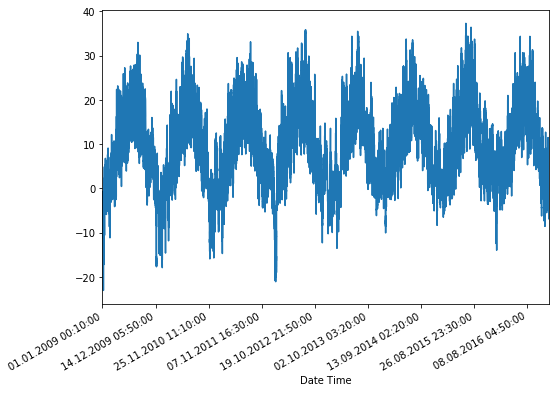

In [35]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

It is important to normalize features before training a neural network. A common way to do so is by subtracting the mean and dividing by the standard deviation of each feature.

Note: The mean and standard deviation should only be computed using the training data.

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's normalize the data.

In [0]:
uni_data = (uni_data - uni_train_mean) / uni_train_std

Let's now create the data for the univariate model. 

For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT, univariate_past_history, univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None, univariate_past_history, univariate_future_target)

This is what the `univariate_data` function returns.

In [40]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps  

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])        

  plt.legend()
  plt.xlim([time_steps[0], (future + 5) * 2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

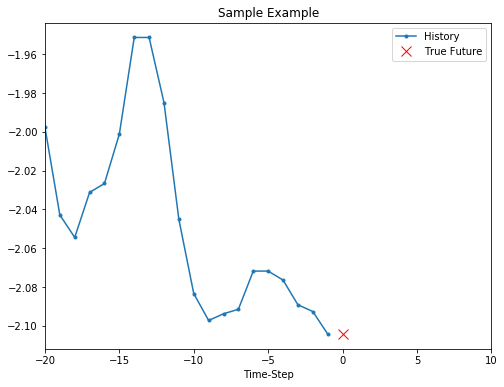

In [43]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline

Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

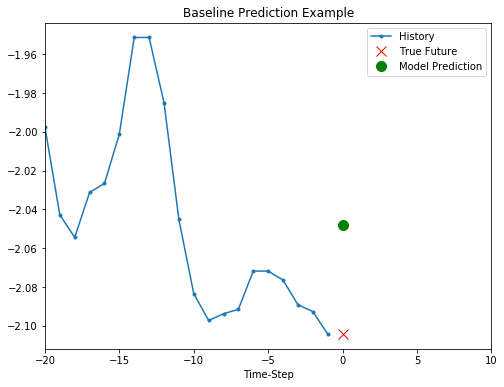

In [45]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

The following visualisation should help you understand how the data is represented after batching.

![Time Series](images/time_series.png)

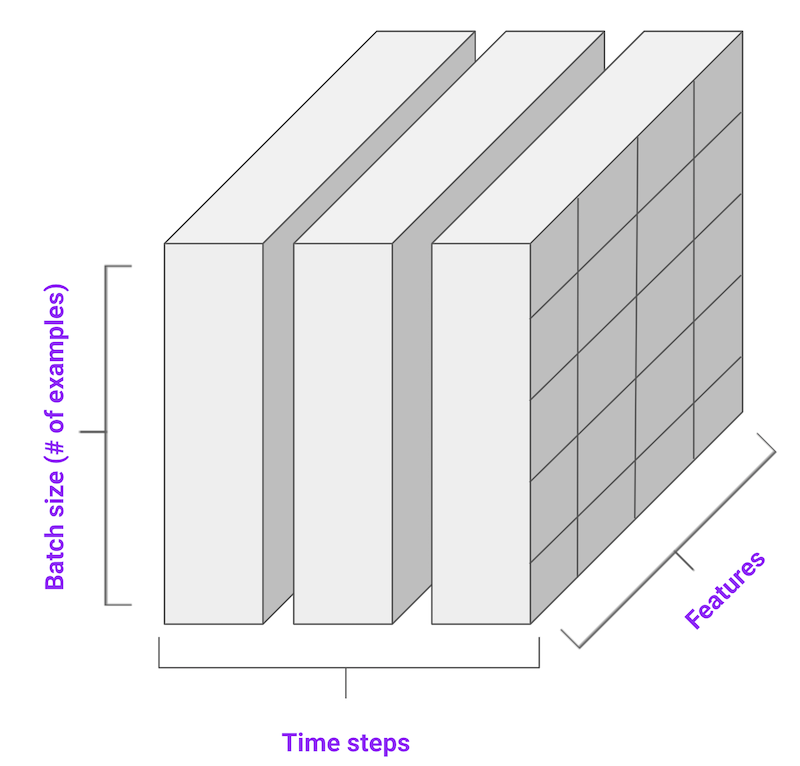

In [47]:
from IPython.display import Image
Image('time_series.png') 

You will see the LSTM requires the input shape of the data it is being given.

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)                                            
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Let's make a sample prediction, to check the output of the model. 

In [49]:
for x , y in val_univariate.take(1):
  print(simple_lstm_model.predict(x).shape)

(256, 1)


Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [50]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 5s 23ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0317 - val_loss: 0.0225
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0286 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0263 - val_loss: 0.0200
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0254 - val_loss: 0.0182
Epoch 10/10
200/200 [===========================

#### Predict using the simple LSTM model

Now that you have trained your simple LSTM, let's try and make a few predictions.

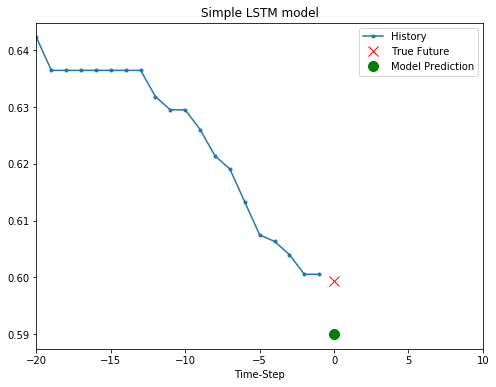

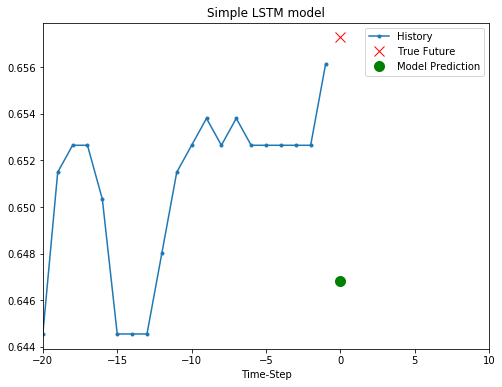

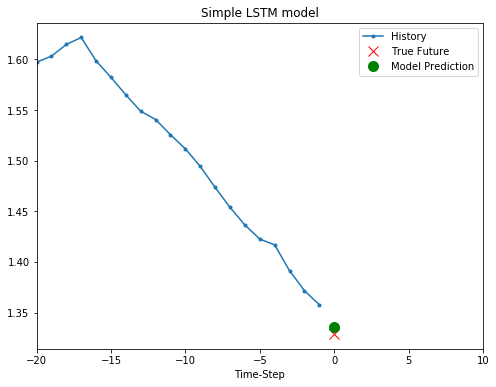

In [51]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

## Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [0]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [53]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


Let's have a look at how each of these features vary across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c49aa0748>,
      dtype=object)

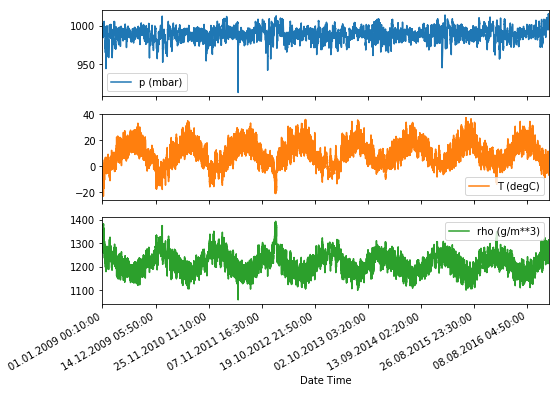

In [54]:
features.plot(subplots=True)

As mentioned, the first step will be to normalize the dataset using the mean and standard deviation of the training data.

In [0]:
dataset = features.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)

In [0]:
dataset = (dataset - data_mean) / data_std

### Single step model

In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.